In [1]:
!pip install utils
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, UpSampling2D, AveragePooling2D,ZeroPadding2D,Convolution2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from IPython.display import SVG, Image
import cv2
import utils

In [2]:
!pip install tensorflow-addons
!pip install wheel
!pip install pandas
!pip install opencv-python
!pip install matplotlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
!pip install -U -q tensorflow-addons
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import numpy as np
import zipfile
from PIL import Image
from tensorflow.keras.utils import to_categorical

# Define the path to your zip file containing the dataset
zip_file_path = '/content/drive/MyDrive/CSE400 Thesis/Pothole Dataset Yolo2.zip'

# Define the directory where you want to extract the dataset
extracted_path = '/Downloads/FINAL_DATASET_TTUUU'

# Create the directory for extracted data
os.makedirs(extracted_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

In [7]:
img_size=(128,128)
batch_size = 32
datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory("/Downloads/FINAL_DATASET_TTUUU/train",
target_size=img_size,
batch_size=batch_size,
class_mode='categorical',
color_mode ="rgb",
shuffle=True)

datagen_validation=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_validation.flow_from_directory("/Downloads/FINAL_DATASET_TTUUU/val",
target_size=img_size,
batch_size=batch_size,
class_mode='categorical',
color_mode ="rgb",
shuffle=True)

datagen_test=ImageDataGenerator(horizontal_flip=True)
test_generator=datagen_test.flow_from_directory("/Downloads/FINAL_DATASET_TTUUU/test",
target_size=img_size,
batch_size=batch_size,
class_mode='categorical',
color_mode ="rgb",
shuffle=True)

Found 7400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Resnet50

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input

In [9]:
resnet = ResNet50(input_shape=[128,128]+ [3], weights=None, include_top=False)

In [10]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [11]:
x = Flatten()(resnet.output)

In [12]:
prediction = Dense(2, activation='sigmoid')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [13]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [14]:
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
optimum= Adam(learning_rate=0.000005)
model.compile(loss='binary_crossentropy', optimizer=optimum, metrics=['accuracy',recall,precision,tf.keras.metrics.AUC(curve="ROC"),tf.keras.metrics.FalsePositives(),tf.keras.metrics.TruePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [16]:
%%time
batch_size = 32


ephocs=100


steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch
validation_steps=validation_generator.n//validation_generator.batch_size
validation_steps
mod = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=ephocs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps
                    )

Epoch 1/100
231/231 [==============================] - 57s 245ms/step - loss: 0.8361 - accuracy: 0.5185 - recall: 0.5183 - precision: 0.5204 - auc: 0.5316 - false_positives: 3568.0000 - true_positives: 3816.0000 - false_negatives: 3552.0000 - true_negatives: 3800.0000 - sensitivity_at_specificity: 0.5274 - val_loss: 0.7616 - val_accuracy: 0.4913 - val_recall: 0.5330 - val_precision: 0.5170 - val_auc: 0.5404 - val_false_positives: 286.0000 - val_true_positives: 307.0000 - val_false_negatives: 269.0000 - val_true_negatives: 290.0000 - val_sensitivity_at_specificity: 0.5365
Epoch 2/100
231/231 [==============================] - 52s 226ms/step - loss: 0.7110 - accuracy: 0.5927 - recall: 0.5762 - precision: 0.5741 - auc: 0.6089 - false_positives: 3158.0000 - true_positives: 4238.0000 - false_negatives: 3130.0000 - true_negatives: 4210.0000 - sensitivity_at_specificity: 0.6360 - val_loss: 0.6656 - val_accuracy: 0.6562 - val_recall: 0.6337 - val_precision: 0.5945 - val_auc: 0.6629 - val_false

In [17]:
model.evaluate(test_generator,verbose=1)

63/63 [==============================] - 14s 221ms/step - loss: 0.2897 - accuracy: 0.8960 - recall: 0.8829 - precision: 0.9023 - auc: 0.9527 - false_positives: 191.0000 - true_positives: 1766.0000 - false_negatives: 234.0000 - true_negatives: 1809.0000 - sensitivity_at_specificity: 0.9855


[0.2897481322288513,
 0.8960000276565552,
 0.8829365372657776,
 0.9023337960243225,
 0.9527208209037781,
 191.0,
 1766.0,
 234.0,
 1809.0,
 0.9854999780654907]

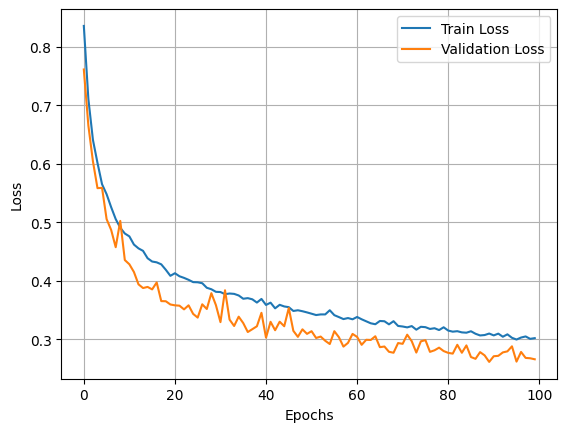

In [18]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.plot(mod.history["loss"], label="Train Loss")
plt.plot(mod.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
mpl.rcParams["figure.dpi"] = 300
plt.legend(['Train', 'Validation'], loc='upper left')
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"
plt.legend()
plt.grid()
plt.show()

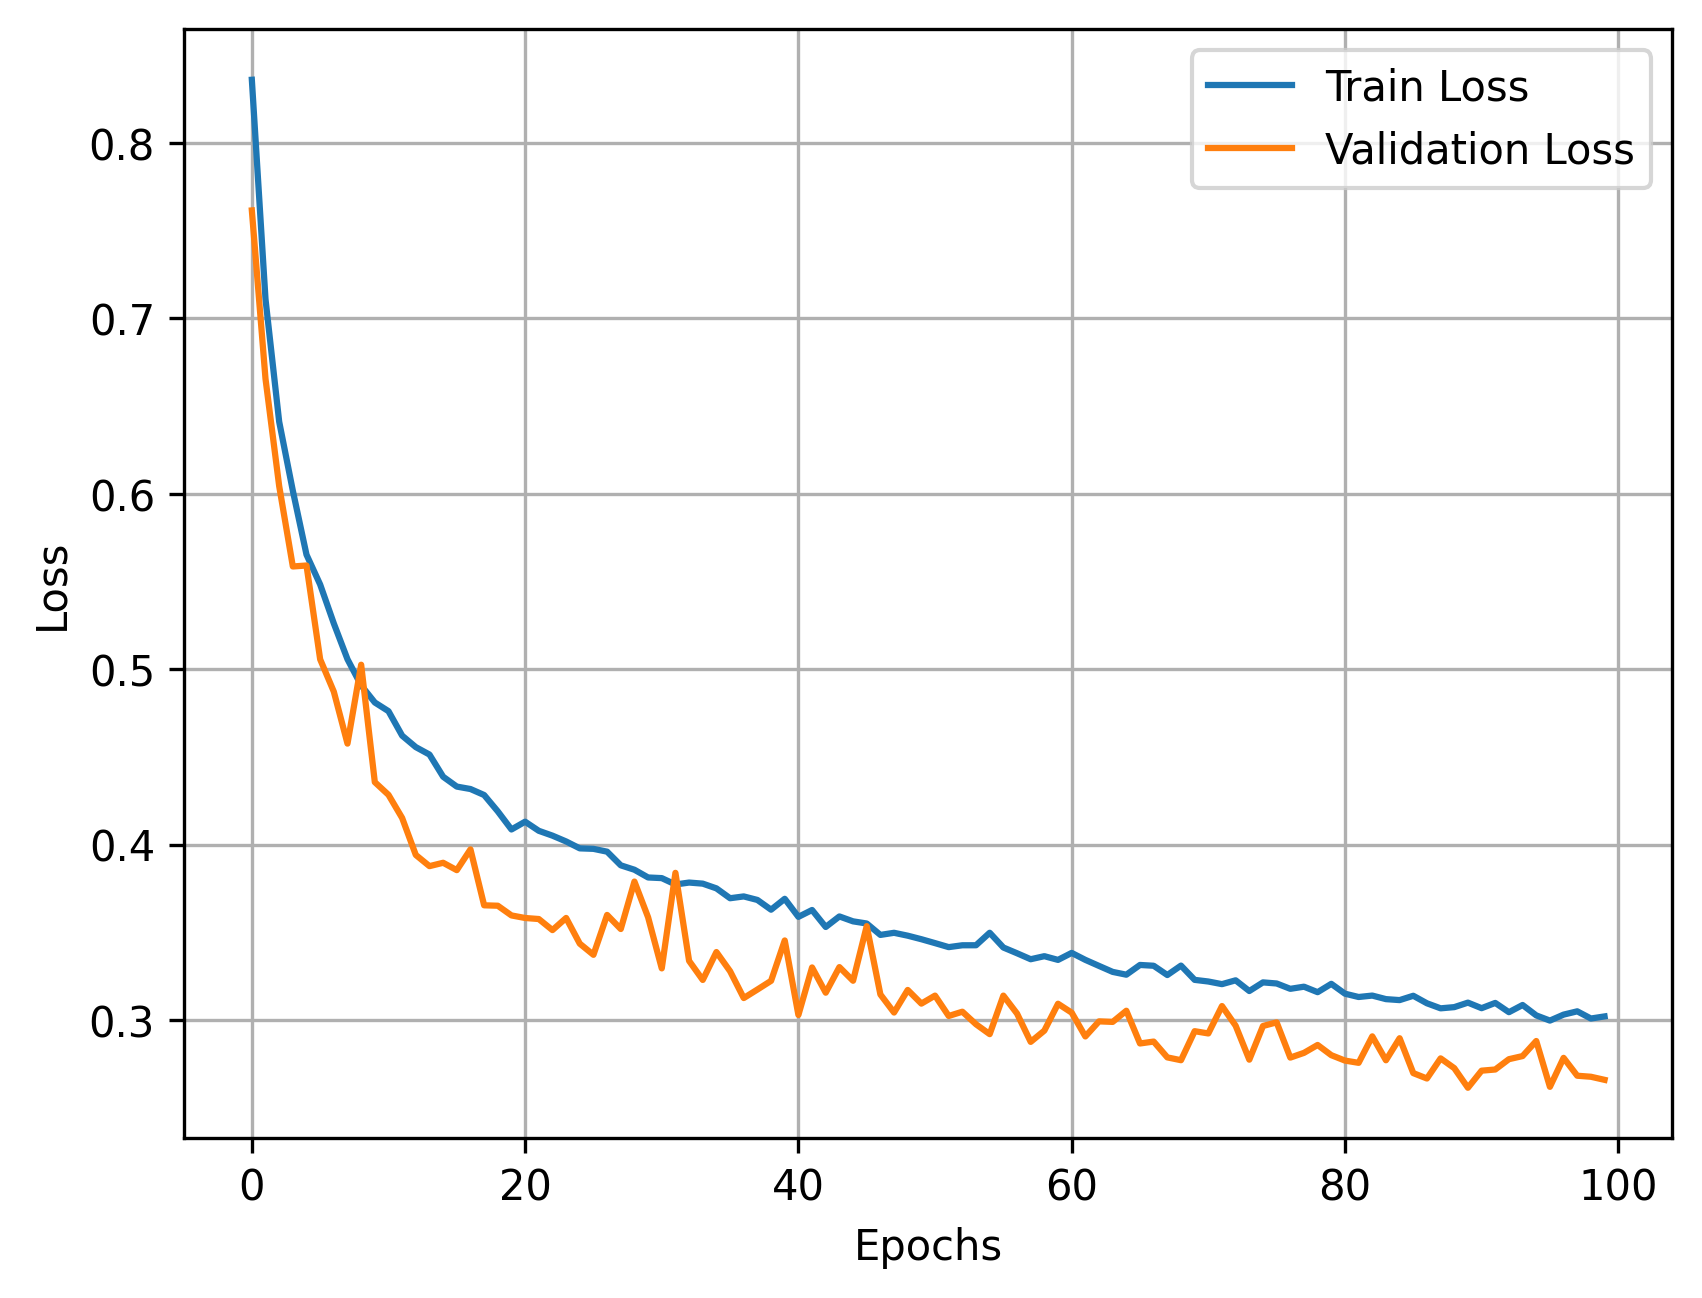

In [19]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.plot(mod.history["loss"], label="Train Loss")
plt.plot(mod.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
mpl.rcParams["figure.dpi"] = 300
plt.legend(['Train', 'Validation'], loc='upper left')
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"
plt.legend()
plt.grid()
plt.show()

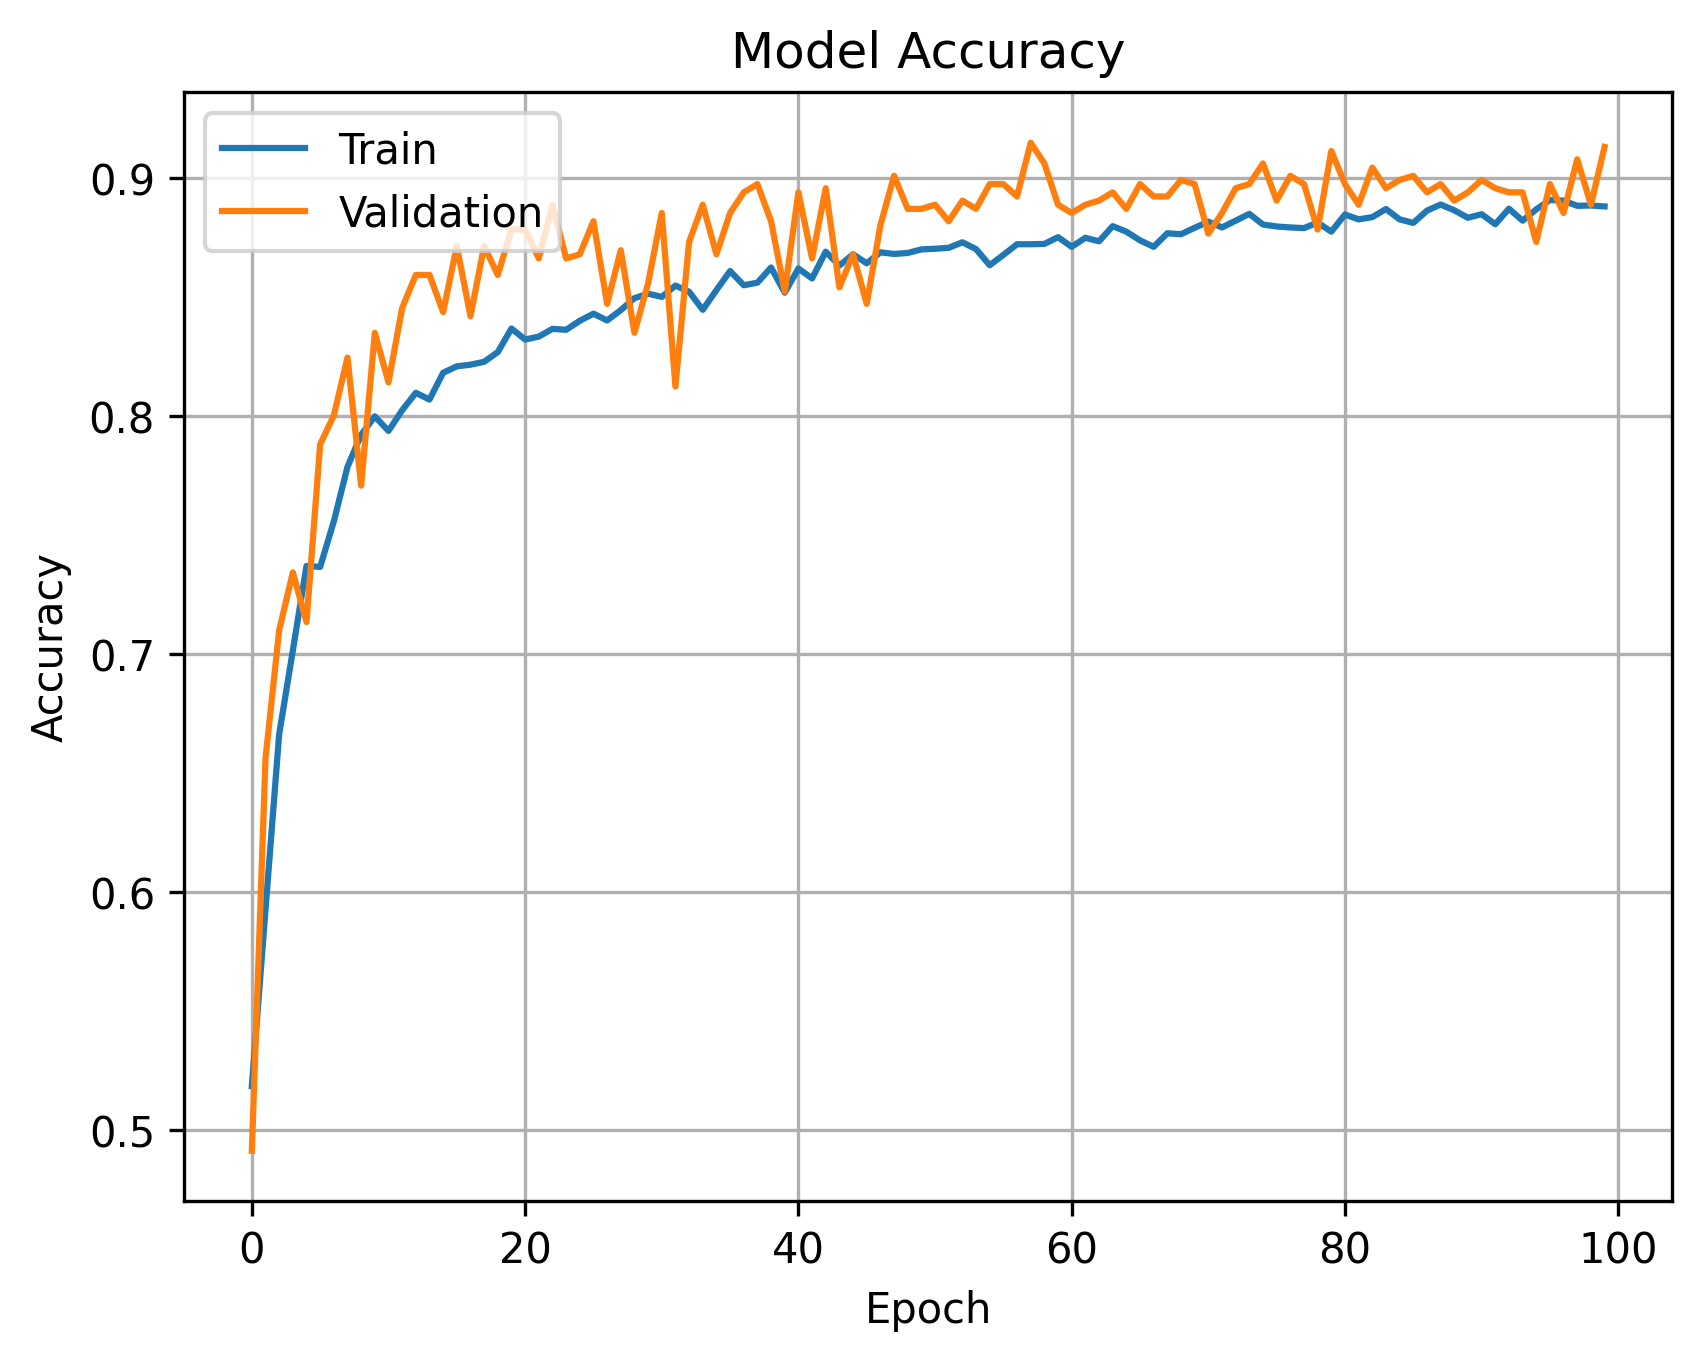

In [20]:
plt.figure(1)
import matplotlib as mpl
plt.plot(mod.history['accuracy'])
plt.plot(mod.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
mpl.rcParams["figure.dpi"] = 300
plt.legend(['Train', 'Validation'], loc='upper left')
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"
plt.grid()
plt.show()

# VGG16

In [21]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

In [22]:
vgg16 = VGG16(input_shape=[128,128]+ [3], weights=None, include_top=False)

In [23]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [24]:
x = Flatten()(vgg16.output)

In [25]:
prediction = Dense(2, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [26]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [27]:
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
optimum= Adam(learning_rate=0.000005)
model.compile(loss='binary_crossentropy', optimizer=optimum, metrics=['accuracy',recall,precision,tf.keras.metrics.AUC(curve="ROC"),tf.keras.metrics.FalsePositives(),tf.keras.metrics.TruePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [29]:
%%time
batch_size = 32


ephocs=100


steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch
validation_steps=validation_generator.n//validation_generator.batch_size
validation_steps
modp = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=ephocs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps
                    )

Epoch 1/100
231/231 [==============================] - 51s 221ms/step - loss: 0.7012 - accuracy: 0.5076 - recall: 0.5748 - precision: 0.5050 - auc_1: 0.4905 - false_positives_1: 4169.0000 - true_positives_1: 4237.0000 - false_negatives_1: 3131.0000 - true_negatives_1: 3199.0000 - sensitivity_at_specificity_1: 0.4821 - val_loss: 0.6947 - val_accuracy: 0.5260 - val_recall: 0.5069 - val_precision: 0.5101 - val_auc_1: 0.5000 - val_false_positives_1: 283.0000 - val_true_positives_1: 292.0000 - val_false_negatives_1: 284.0000 - val_true_negatives_1: 293.0000 - val_sensitivity_at_specificity_1: 0.4688
Epoch 2/100
231/231 [==============================] - 50s 215ms/step - loss: 0.6933 - accuracy: 0.5280 - recall: 0.5555 - precision: 0.5210 - auc_1: 0.5196 - false_positives_1: 3767.0000 - true_positives_1: 4094.0000 - false_negatives_1: 3274.0000 - true_negatives_1: 3601.0000 - sensitivity_at_specificity_1: 0.4921 - val_loss: 0.6928 - val_accuracy: 0.5312 - val_recall: 0.4809 - val_precision: 

In [30]:
model.evaluate(test_generator,verbose=1)

63/63 [==============================] - 15s 240ms/step - loss: 0.5374 - accuracy: 0.7815 - recall: 0.7808 - precision: 0.7813 - auc_1: 0.8449 - false_positives_1: 438.0000 - true_positives_1: 1561.0000 - false_negatives_1: 439.0000 - true_negatives_1: 1562.0000 - sensitivity_at_specificity_1: 0.9205


[0.5374046564102173,
 0.781499981880188,
 0.7807539701461792,
 0.7812520265579224,
 0.8448832631111145,
 438.0,
 1561.0,
 439.0,
 1562.0,
 0.9204999804496765]

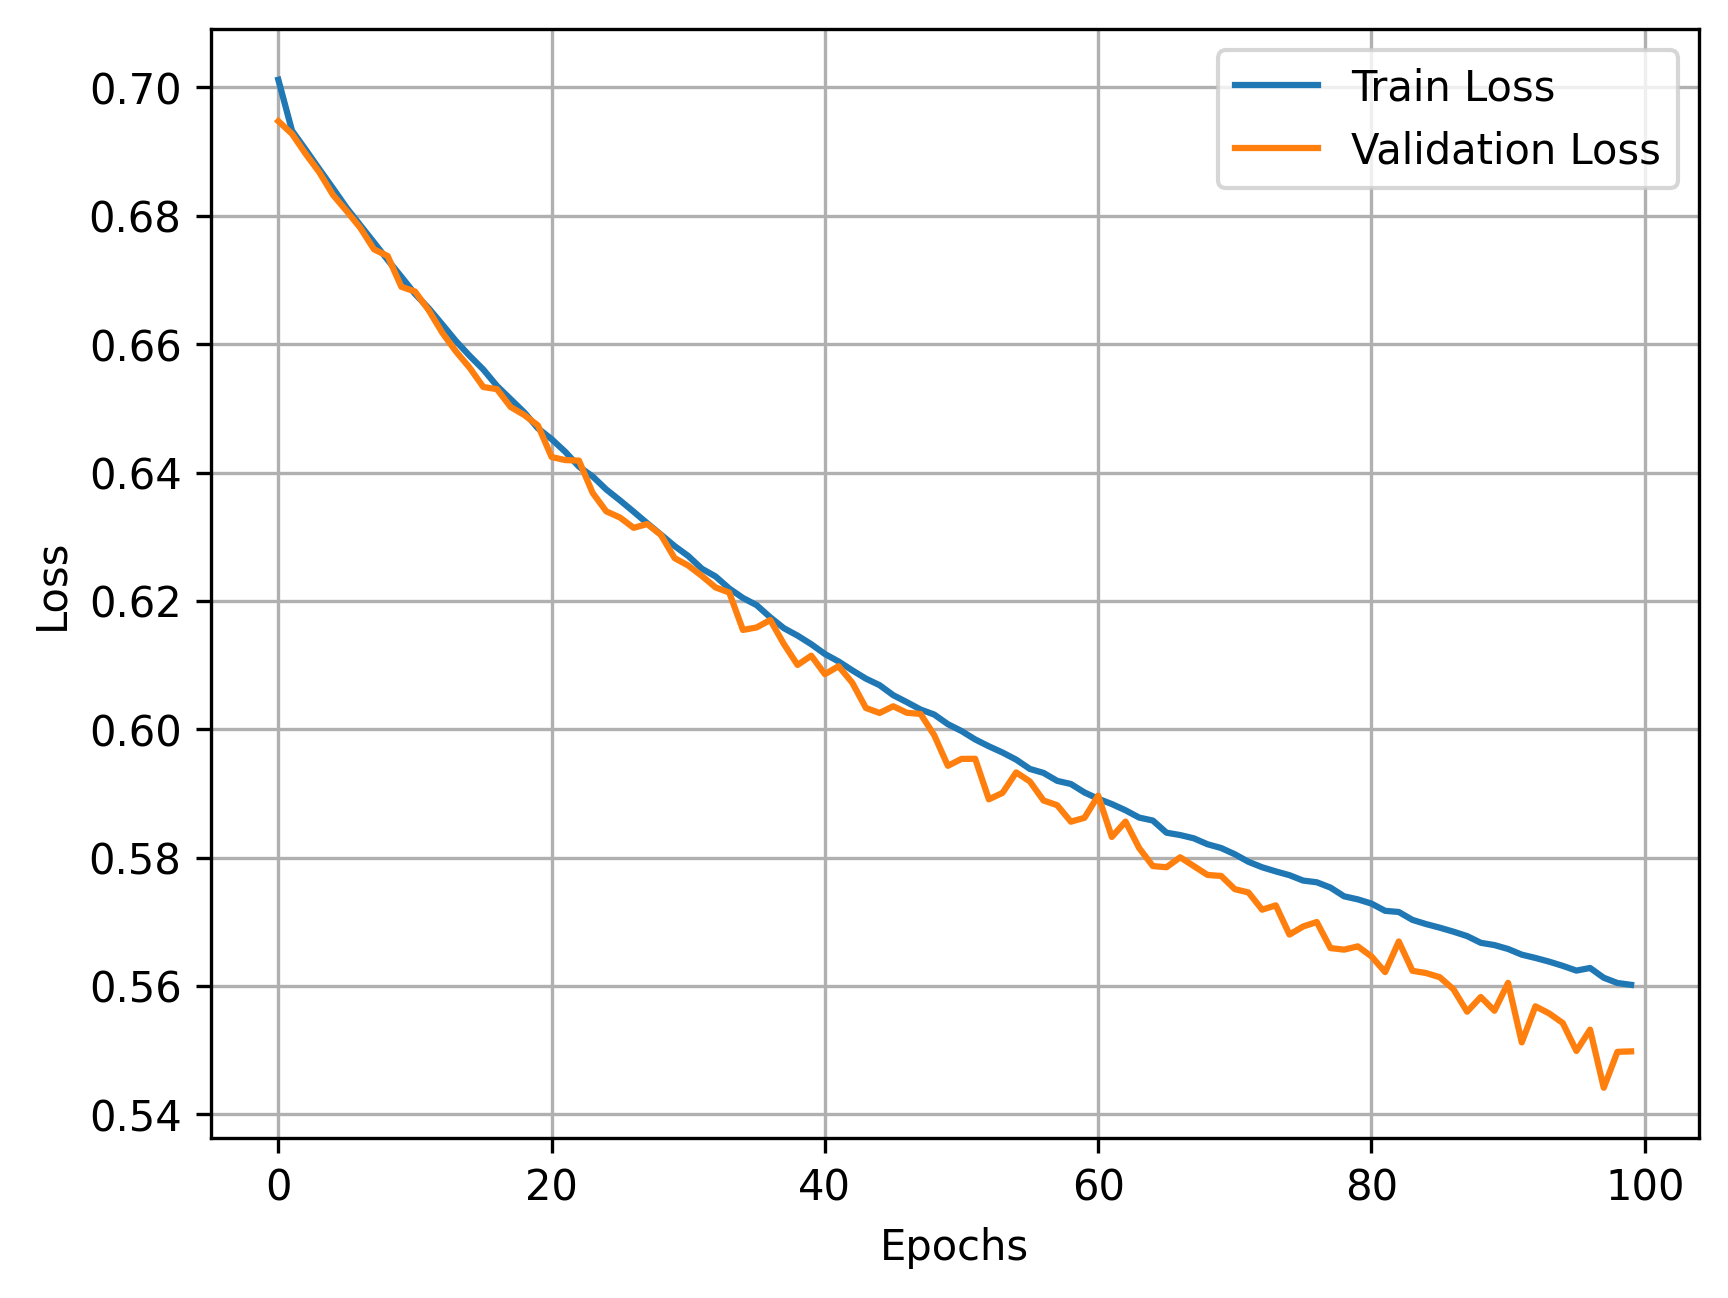

In [31]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.plot(modp.history["loss"], label="Train Loss")
plt.plot(modp.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
mpl.rcParams["figure.dpi"] = 300
plt.legend(['Train', 'Validation'], loc='upper left')
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"
plt.legend()
plt.grid()
plt.show()

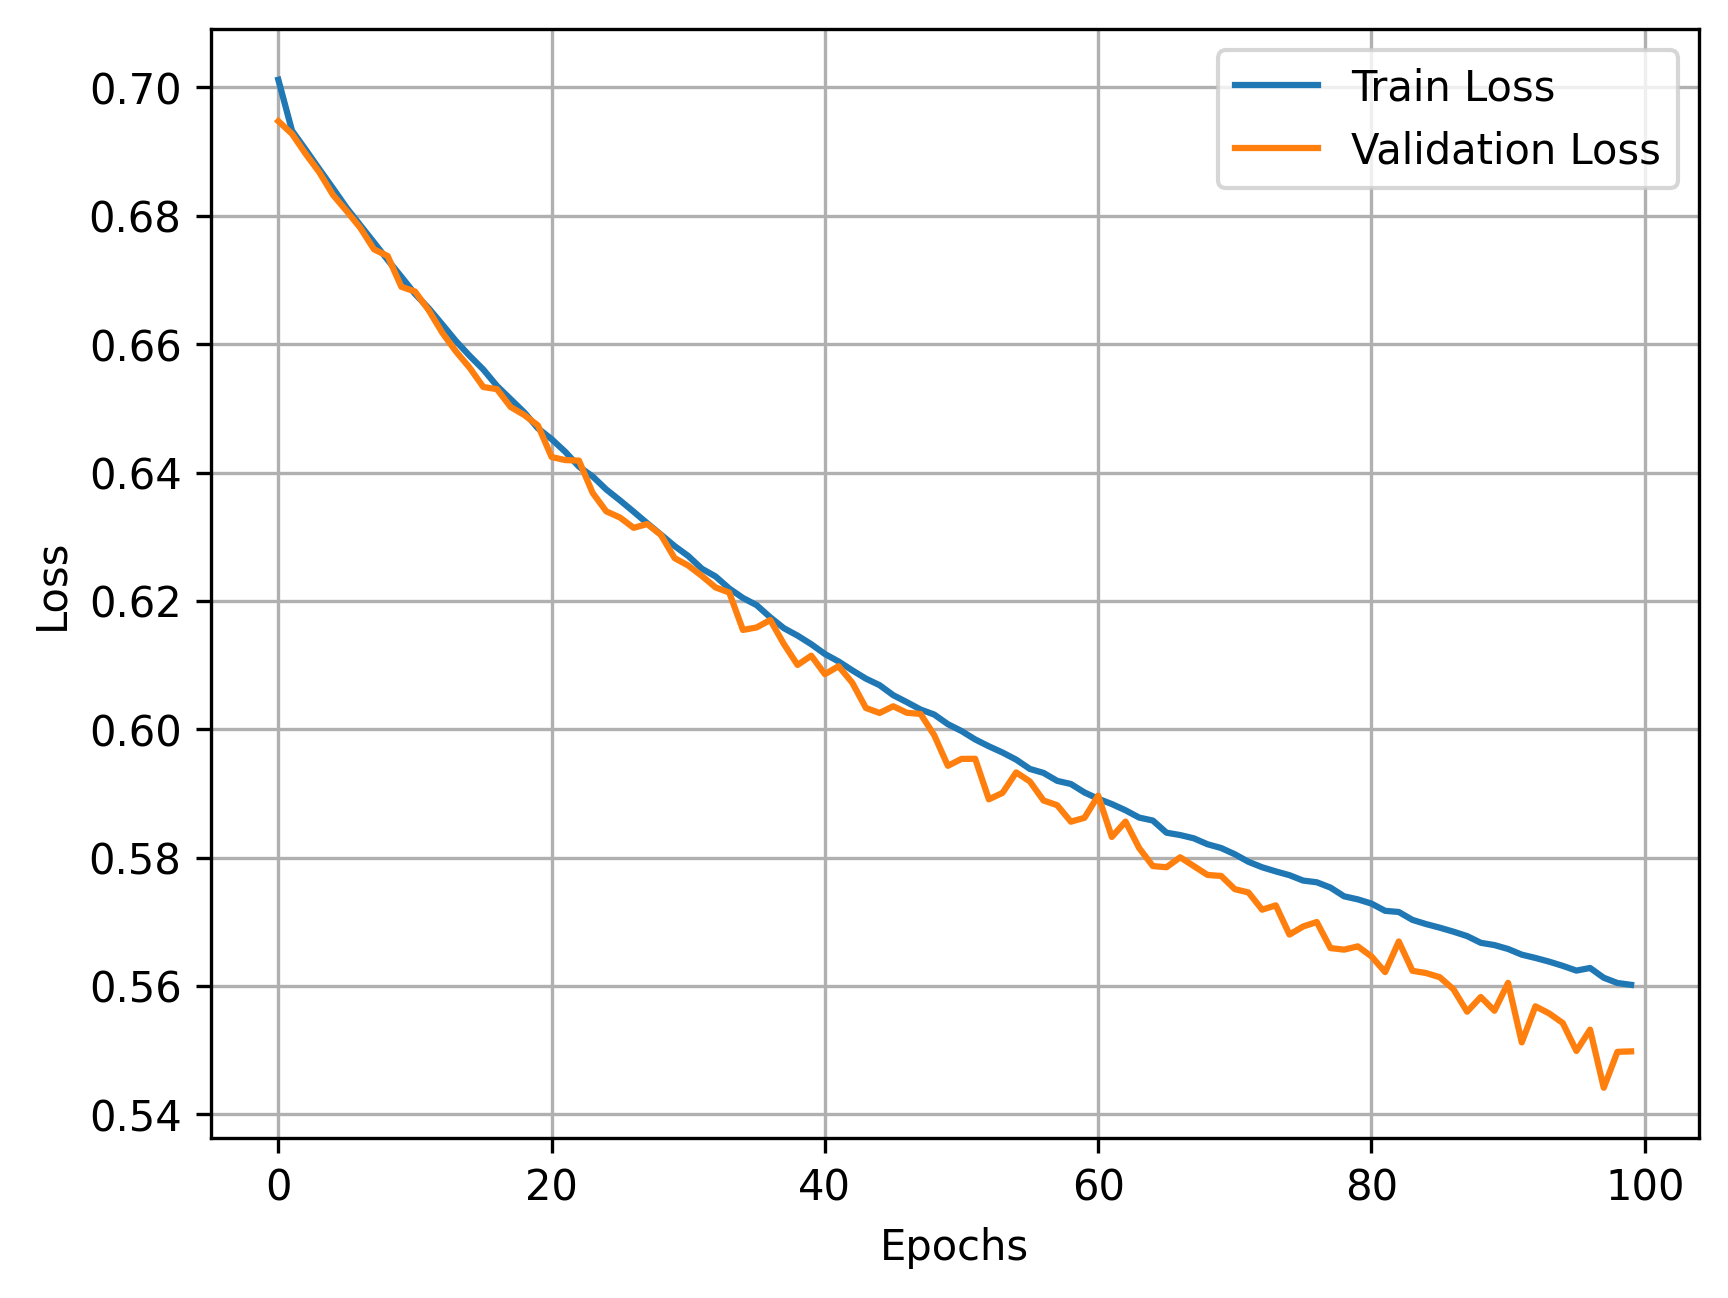

In [32]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.plot(modp.history["loss"], label="Train Loss")
plt.plot(modp.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
mpl.rcParams["figure.dpi"] = 300
plt.legend(['Train', 'Validation'], loc='upper left')
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"
plt.legend()
plt.grid()
plt.show()

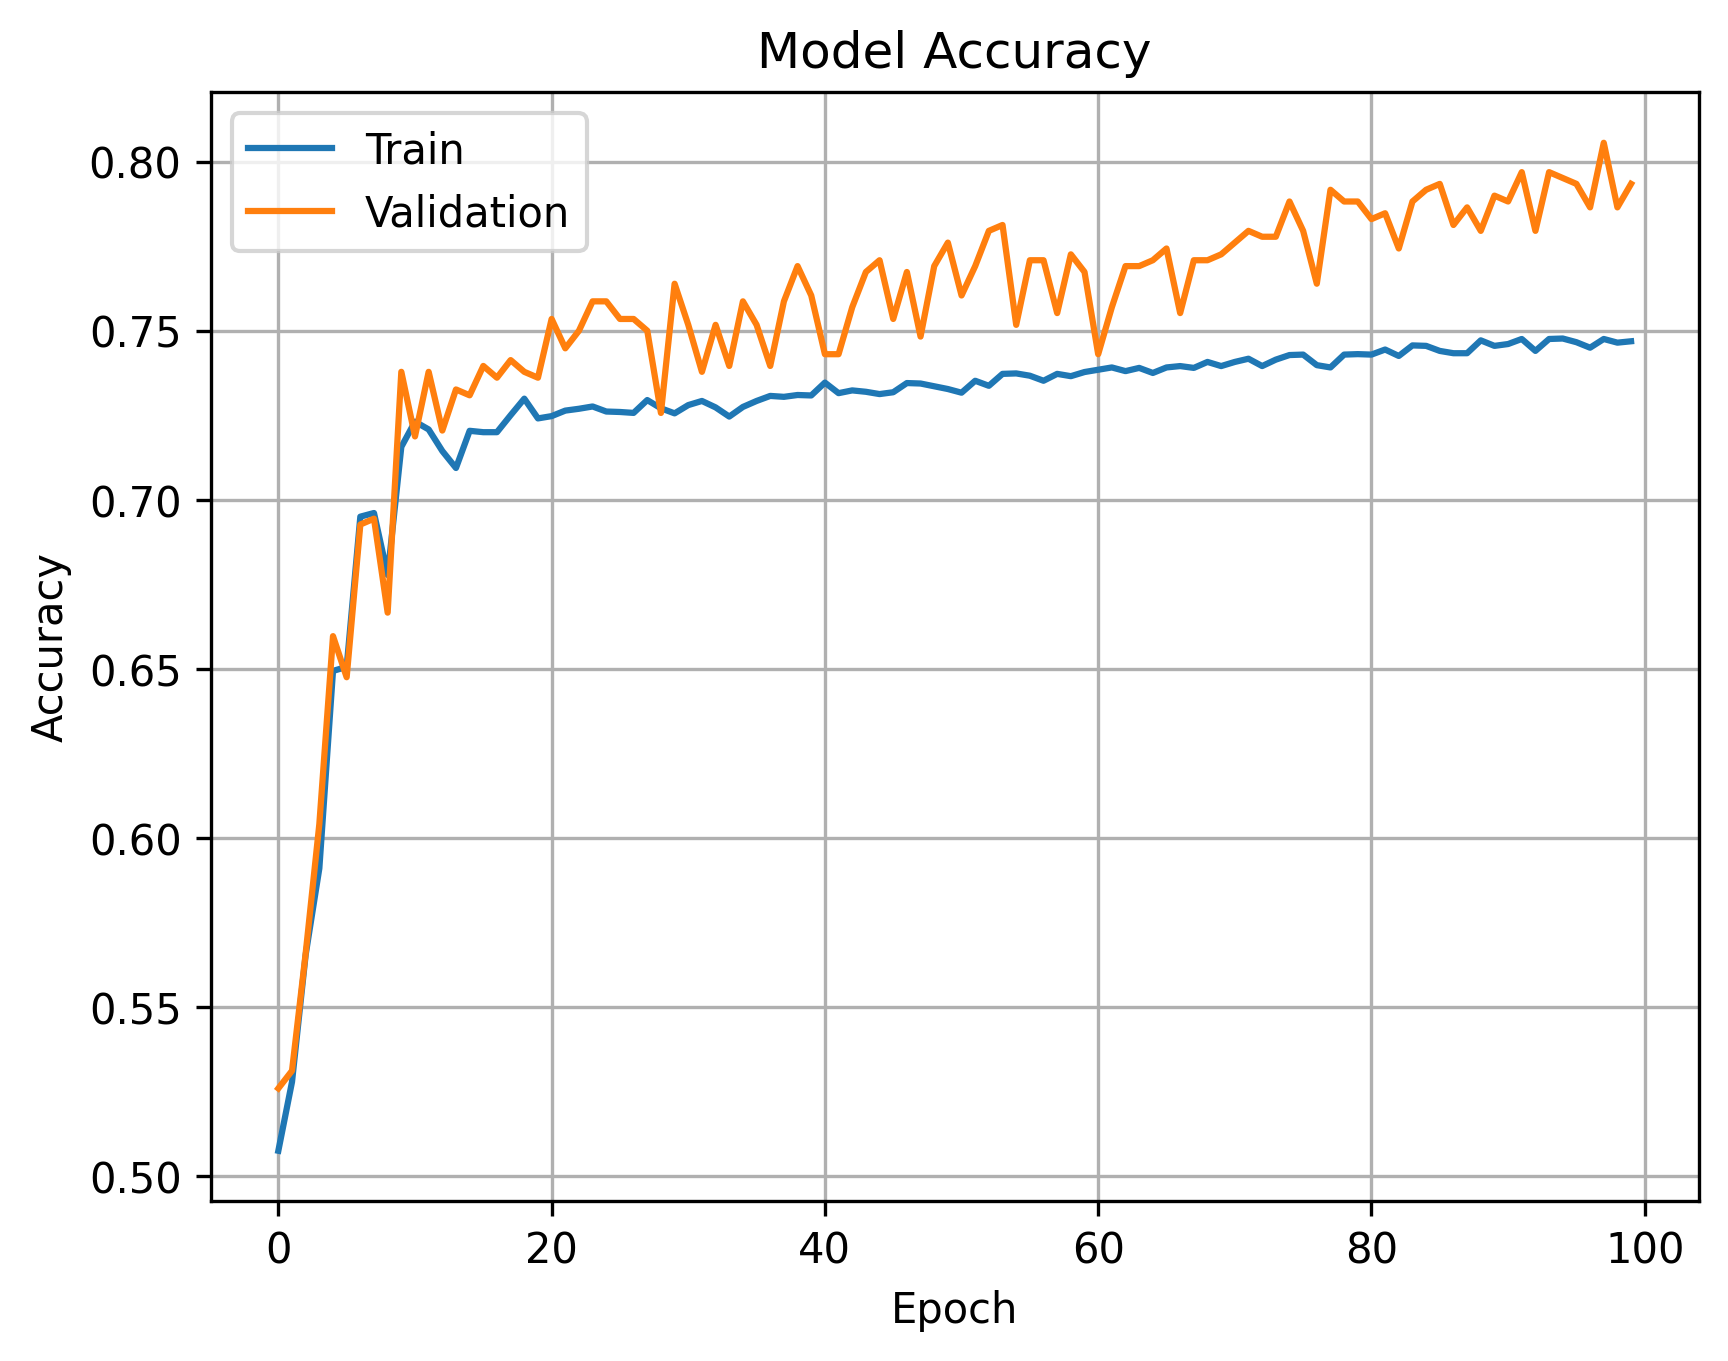

In [33]:
plt.figure(1)
import matplotlib as mpl
plt.plot(modp.history['accuracy'])
plt.plot(modp.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
mpl.rcParams["figure.dpi"] = 300
plt.legend(['Train', 'Validation'], loc='upper left')
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"
plt.grid()
plt.show()